# Code alongs - overfitting and underfitting

## Simulate data 

$y = a_0 + a_1x + a_2x^2 + \epsilon$

where $\epsilon \sim \mathcal{N}(0,1)$ (the error is standard normal distributed)

In [3]:
import numpy as np 
import matplotlib.pyplot as plt 

samples = 100 
X = np.random.uniform(-3,3, (samples, 1))
X.shape


(100, 1)

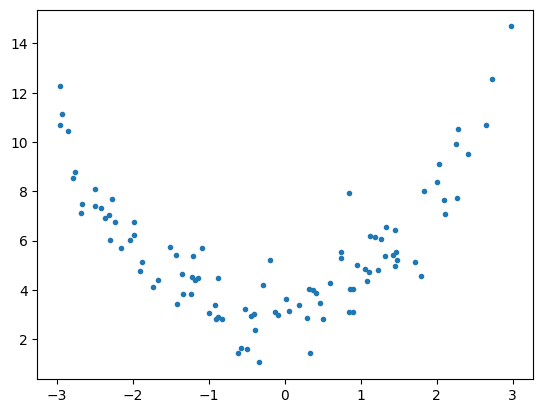

In [10]:
# a0 = 3, a1 = 0.5, a2 = 1
f = lambda x: x**2 + 0.5*x + 3
y = f(X) + np.random.randn(samples, 1)

x = np.linspace(-3,3, samples )
plt.plot(X,y, '.')